# Chapter 4: Neural Networks

This notebook covers **Chapter 4** of the Deep Learning in Hebrew book, focusing on neural networks. We'll learn how to build multi-layer neural networks that can handle non-linear relationships and complex patterns in data.

## Overview

In Chapter 3, we learned about linear models (linear regression and logistic regression) that can be viewed as single-layer neural networks. While these models are powerful, they have limitations - they can only learn linear decision boundaries.

In this chapter, we'll extend these concepts to **multi-layer neural networks** (also called Multi-Layer Perceptrons or MLPs), which can learn non-linear patterns by stacking multiple layers of neurons with non-linear activation functions.

We'll cover:
1. **Multi-Layer Perceptrons (MLPs)** - Building deeper networks
2. **Forward Propagation** - How information flows through the network
3. **Backpropagation** - How to train multi-layer networks
4. **Activation Functions** - Non-linear transformations
5. **Building and Training Neural Networks** - Practical implementation

---

## Table of Contents

### 4.1 Multi-Layer Perceptrons
- 4.1.1 [From Linear to Non-Linear Models](#411-from-linear-to-non-linear-models)
- 4.1.2 [Network Architecture](#412-network-architecture)
- 4.1.3 [Layer Types](#413-layer-types)

### 4.2 Forward Propagation
- 4.2.1 [Matrix Formulation](#421-matrix-formulation)
- 4.2.2 [Vectorized Implementation](#422-vectorized-implementation)

### 4.3 Backpropagation
- 4.3.1 [The Chain Rule](#431-the-chain-rule)
- 4.3.2 [Gradient Computation](#432-gradient-computation)
- 4.3.3 [Backpropagation Algorithm](#433-backpropagation-algorithm)

### 4.4 Activation Functions
- 4.4.1 [Sigmoid and Tanh](#441-sigmoid-and-tanh)
- 4.4.2 [ReLU and Variants](#442-relu-and-variants)
- 4.4.3 [Choosing Activation Functions](#443-choosing-activation-functions)

### 4.5 Building Neural Networks
- 4.5.1 [Network Initialization](#451-network-initialization)
- 4.5.2 [Training Process](#452-training-process)
- 4.5.3 [Practical Considerations](#453-practical-considerations)

## Setup and Imports

Let's start by importing the necessary libraries for this chapter.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 4.1 Multi-Layer Perceptrons

## 4.1.1 From Linear to Non-Linear Models

In Chapter 3, we saw that linear models (linear regression, logistic regression) can be represented as single-layer neural networks. However, these models have a fundamental limitation: they can only learn **linear decision boundaries**.

### The Limitation of Linear Models

Consider the XOR problem - a classic example where linear models fail. The XOR function outputs 1 when the inputs are different, and 0 when they are the same:

| $x_1$ | $x_2$ | XOR |
|-------|-------|-----|
| 0     | 0     | 0   |
| 0     | 1     | 1   |
| 1     | 0     | 1   |
| 1     | 1     | 0   |

This problem is **not linearly separable** - there is no single line that can separate the two classes.

### Solution: Multi-Layer Networks

By adding **hidden layers** between the input and output, we can learn non-linear decision boundaries. A Multi-Layer Perceptron (MLP) consists of:

1. **Input Layer**: Receives the input features
2. **Hidden Layers**: One or more layers of neurons with non-linear activation functions
3. **Output Layer**: Produces the final prediction

The key insight is that by composing multiple linear transformations with non-linear activations, we can approximate any continuous function (Universal Approximation Theorem).

XOR Problem:
Input | True Label | Linear Model Prediction
--------------------------------------------------
[0 0] |           0 |                       0
[0 1] |           1 |                       0
[1 0] |           1 |                       0
[1 1] |           0 |                       0

Linear Model Accuracy: 50.00%


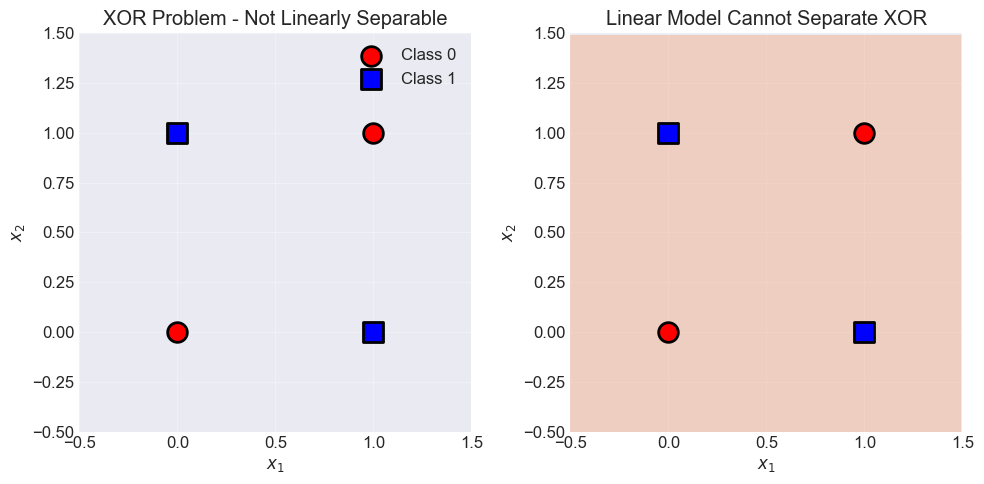

In [7]:
# Demonstrate the XOR problem - linear models fail
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

# Try linear classifier (logistic regression)
from sklearn.linear_model import LogisticRegression
linear_model = LogisticRegression()
linear_model.fit(X_xor, y_xor)
linear_pred = linear_model.predict(X_xor)

print("XOR Problem:")
print("Input | True Label | Linear Model Prediction")
print("-" * 50)
for i, (x, y_true, y_pred) in enumerate(zip(X_xor, y_xor, linear_pred)):
    print(f"{x} | {y_true:11d} | {y_pred:23d}")

print(f"\nLinear Model Accuracy: {accuracy_score(y_xor, linear_pred):.2%}")

# Visualize
plt.figure(figsize=(10, 5))

# Plot 1: XOR data
plt.subplot(1, 2, 1)
colors = ['red' if y == 0 else 'blue' for y in y_xor]
for i, (x, y, c) in enumerate(zip(X_xor, y_xor, colors)):
    plt.scatter(x[0], x[1], c=c, s=200, marker='o' if y == 0 else 's', 
                edgecolors='black', linewidths=2, label=f'Class {y}' if i < 2 else '')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('XOR Problem - Not Linearly Separable')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Plot 2: Decision boundary attempt
plt.subplot(1, 2, 2)
h = 0.01
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = linear_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
for i, (x, y, c) in enumerate(zip(X_xor, y_xor, colors)):
    plt.scatter(x[0], x[1], c=c, s=200, marker='o' if y == 0 else 's',
                edgecolors='black', linewidths=2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Linear Model Cannot Separate XOR')
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

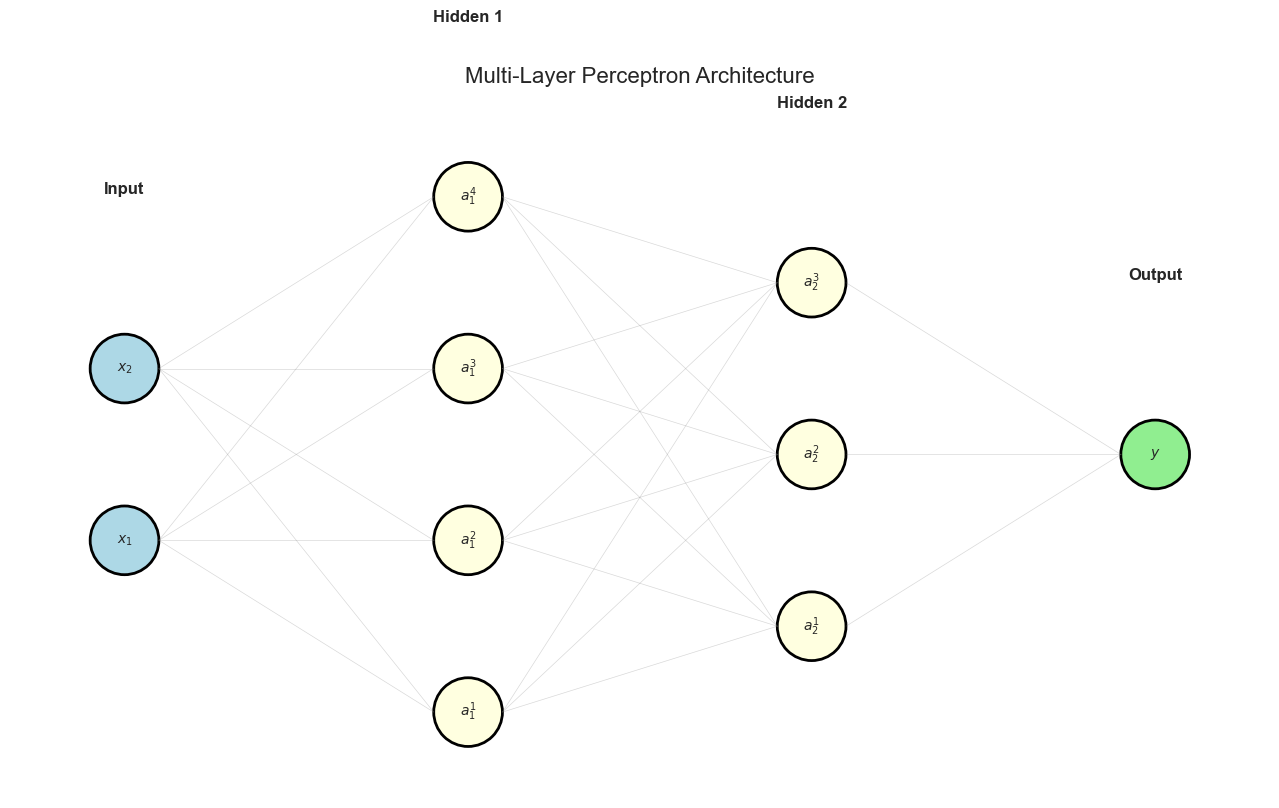

In [8]:
# Visualize network architecture
def plot_network_architecture(input_dim=2, hidden_dims=[4, 3], output_dim=1):
    """Visualize a multi-layer neural network architecture."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    layers = [input_dim] + hidden_dims + [output_dim]
    layer_names = ['Input'] + [f'Hidden {i+1}' for i in range(len(hidden_dims))] + ['Output']
    
    # Calculate positions
    n_layers = len(layers)
    layer_spacing = 3
    neuron_spacing = 1.5
    
    for layer_idx, (n_neurons, layer_name) in enumerate(zip(layers, layer_names)):
        x_pos = layer_idx * layer_spacing
        y_center = (n_neurons - 1) * neuron_spacing / 2
        
        # Draw neurons
        for neuron_idx in range(n_neurons):
            y_pos = neuron_idx * neuron_spacing - y_center
            circle = plt.Circle((x_pos, y_pos), 0.3, 
                              color='lightblue' if layer_idx == 0 else 
                                    'lightgreen' if layer_idx == n_layers - 1 else 'lightyellow',
                              ec='black', lw=2)
            ax.add_patch(circle)
            
            # Label
            if layer_idx == 0:
                label = f'$x_{neuron_idx+1}$'
            elif layer_idx == n_layers - 1:
                label = f'$y_{neuron_idx+1}$' if output_dim > 1 else '$y$'
            else:
                label = f'$a_{{{layer_idx}}}^{{{neuron_idx+1}}}$'
            ax.text(x_pos, y_pos, label, ha='center', va='center', fontsize=10)
        
        # Layer name
        ax.text(x_pos, y_center + 1.5, layer_name, ha='center', va='bottom', 
                fontsize=12, weight='bold')
        
        # Draw connections to next layer
        if layer_idx < n_layers - 1:
            next_n_neurons = layers[layer_idx + 1]
            next_y_center = (next_n_neurons - 1) * neuron_spacing / 2
            
            for i in range(n_neurons):
                y1 = i * neuron_spacing - y_center
                for j in range(next_n_neurons):
                    y2 = j * neuron_spacing - next_y_center
                    ax.plot([x_pos + 0.3, x_pos + layer_spacing - 0.3], 
                           [y1, y2], 'gray', alpha=0.3, linewidth=0.5)
    
    ax.set_xlim(-1, (n_layers - 1) * layer_spacing + 1)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Multi-Layer Perceptron Architecture', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Example: Network with 2 inputs, 2 hidden layers (4 and 3 neurons), 1 output
plot_network_architecture(input_dim=2, hidden_dims=[4, 3], output_dim=1)

## 4.1.3 Layer Types

In a neural network, we have different types of layers:

### Fully Connected (Dense) Layers

Each neuron in a layer is connected to every neuron in the previous layer. This is the most common type of layer in MLPs.

### Input Layer

The input layer receives the raw features. No computation is performed here - it just passes the data to the first hidden layer.

### Hidden Layers

Hidden layers perform the non-linear transformations. They typically use activation functions like ReLU, sigmoid, or tanh.

### Output Layer

The output layer produces the final prediction:
- **Regression**: Linear activation (or no activation)
- **Binary Classification**: Sigmoid activation
- **Multi-class Classification**: SoftMax activation

# 4.2 Forward Propagation

Forward propagation is the process of passing input data through the network to compute the output. It's called "forward" because information flows from input to output.

## 4.2.1 Matrix Formulation

For a single example $x \in \mathbb{R}^d$, forward propagation through layer $l$ is:

$$z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)}$$

$$a^{(l)} = g^{(l)}(z^{(l)})$$

where:
- $a^{(0)} = x$ (input)
- $W^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}}$ is the weight matrix
- $b^{(l)} \in \mathbb{R}^{n_l}$ is the bias vector
- $g^{(l)}$ is the activation function

### For a Batch of Examples

When processing multiple examples simultaneously (batch processing), we stack them into a matrix:

- Input: $X \in \mathbb{R}^{m \times d}$ where $m$ is the batch size
- Layer $l$ output: $A^{(l)} \in \mathbb{R}^{m \times n_l}$

The forward propagation becomes:

$$Z^{(l)} = A^{(l-1)} (W^{(l)})^T + \mathbf{1} (b^{(l)})^T$$

$$A^{(l)} = g^{(l)}(Z^{(l)})$$

where $\mathbf{1}$ is a column vector of ones.

In [9]:
# Forward Propagation Implementation
class MLP:
    """
    Multi-Layer Perceptron with forward propagation.
    """
    def __init__(self, layer_dims, activation='relu', output_activation='linear'):
        """
        Initialize MLP.
        
        Parameters:
        -----------
        layer_dims : list
            List of layer dimensions [input_dim, hidden1, hidden2, ..., output_dim]
        activation : str
            Activation function for hidden layers ('relu', 'sigmoid', 'tanh')
        output_activation : str
            Activation function for output layer ('linear', 'sigmoid', 'softmax')
        """
        self.layer_dims = layer_dims
        self.activation = activation
        self.output_activation = output_activation
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(len(layer_dims) - 1):
            # Xavier/Glorot initialization
            w = np.random.randn(layer_dims[i+1], layer_dims[i]) * np.sqrt(2.0 / layer_dims[i])
            b = np.zeros((layer_dims[i+1], 1))
            self.weights.append(w)
            self.biases.append(b)
    
    def _activate(self, z, activation_type):
        """Apply activation function."""
        if activation_type == 'relu':
            return np.maximum(0, z)
        elif activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        elif activation_type == 'tanh':
            return np.tanh(z)
        elif activation_type == 'softmax':
            exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        elif activation_type == 'linear':
            return z
        else:
            return z
    
    def forward(self, X):
        """
        Forward propagation.
        """
        # Store activations consistently as (n_units, m)
        cache = {'A': [X.T]}
        A = X.T  # (n_features, m)

        # Forward through hidden layers
        for i in range(len(self.weights) - 1):
            Z = self.weights[i] @ A + self.biases[i]          # (n_i, m)
            A = self._activate(Z, self.activation)            # (n_i, m)
            cache['A'].append(A)
            cache[f'Z_{i}'] = Z

        # Output layer
        i = len(self.weights) - 1
        Z = self.weights[i] @ A + self.biases[i]              # (n_out, m)
        A = self._activate(Z, self.output_activation)         # (n_out, m)
        cache['A'].append(A)
        cache[f'Z_{i}'] = Z

        return A.T, cache  # (m, n_out)

# Test forward propagation
mlp = MLP(layer_dims=[2, 4, 3, 1], activation='relu', output_activation='sigmoid')
X_test = np.random.randn(5, 2)  # 5 examples, 2 features
output, cache = mlp.forward(X_test)

print("Forward Propagation Test:")
print(f"Input shape: {X_test.shape}")
print(f"Output shape: {output.shape}")
print(f"Output values:\n{output}")
print(f"\nNumber of layers: {len(mlp.weights)}")
for i, (w, b) in enumerate(zip(mlp.weights, mlp.biases)):
    print(f"Layer {i+1}: W shape {w.shape}, b shape {b.shape}")

Forward Propagation Test:
Input shape: (5, 2)
Output shape: (5, 1)
Output values:
[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]

Number of layers: 3
Layer 1: W shape (4, 2), b shape (4, 1)
Layer 2: W shape (3, 4), b shape (3, 1)
Layer 3: W shape (1, 3), b shape (1, 1)


# 4.3 Backpropagation

Backpropagation is the algorithm used to train neural networks. It computes the gradients of the loss function with respect to all parameters in the network, allowing us to update the weights using gradient descent.

## 4.3.1 The Chain Rule

Backpropagation is based on the **chain rule** from calculus. For a composite function $f(g(x))$, the derivative is:

$$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

In neural networks, the loss $L$ depends on the output $a^{(L)}$, which depends on $z^{(L)}$, which depends on $W^{(L)}$ and $b^{(L)}$, and so on. We use the chain rule to compute gradients layer by layer, starting from the output and moving backward.

### Gradient Flow

For the output layer $L$:

$$\frac{\partial L}{\partial z^{(L)}} = \frac{\partial L}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial z^{(L)}}$$

For hidden layer $l$:

$$\frac{\partial L}{\partial z^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \cdot \frac{\partial a^{(l)}}{\partial z^{(l)}}$$

where:

$$\frac{\partial L}{\partial a^{(l)}} = (W^{(l+1)})^T \frac{\partial L}{\partial z^{(l+1)}}$$

This shows how gradients flow backward through the network.

## 4.3.2 Gradient Computation

For a network with $L$ layers, we need to compute gradients for all weights and biases.

### Output Layer Gradients

For the output layer:

$$\frac{\partial L}{\partial W^{(L)}} = \frac{\partial L}{\partial z^{(L)}} \cdot (a^{(L-1)})^T$$

$$\frac{\partial L}{\partial b^{(L)}} = \frac{\partial L}{\partial z^{(L)}}$$

### Hidden Layer Gradients

For hidden layer $l$:

$$\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial z^{(l)}} \cdot (a^{(l-1)})^T$$

$$\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial z^{(l)}}$$

where:

$$\frac{\partial L}{\partial z^{(l)}} = \frac{\partial L}{\partial a^{(l)}} \odot g'^{(l)}(z^{(l)})$$

and $\odot$ denotes element-wise multiplication (Hadamard product).

### Loss Function Derivatives

For common loss functions:

**Mean Squared Error (MSE)**:
$$L = \frac{1}{2m}\sum_{i=1}^{m}(y^{(i)} - \hat{y}^{(i)})^2$$
$$\frac{\partial L}{\partial \hat{y}} = \frac{1}{m}(\hat{y} - y)$$

**Cross-Entropy (with SoftMax)**:
$$L = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}\log(\hat{y}_k^{(i)})$$
$$\frac{\partial L}{\partial \hat{y}} = -\frac{1}{m}\frac{y}{\hat{y}}$$

In [10]:
# Backpropagation Implementation
def backward_propagation(y, output, cache, mlp, loss_type='mse'):
    """
    Backward propagation to compute gradients.
    
    Parameters:
    -----------
    y : array
        True labels
    output : array
        Network output
    cache : dict
        Cache from forward propagation
    mlp : MLP
        The neural network
    loss_type : str
        Type of loss function ('mse' or 'cross_entropy')
    
    Returns:
    --------
    grads : dict
        Gradients for weights and biases
    """
    m = y.shape[0]
    grads = {}

    # Work internally with (n_out, m) to match cache convention
    y_T = y.T
    out_T = output.T

    # dL/dA for output
    if loss_type == 'mse':
        dA = (out_T - y_T)  # (n_out, m)
    elif loss_type == 'cross_entropy':
        dA = -y_T / (out_T + 1e-15)  # (n_out, m)
    else:
        dA = (out_T - y_T)

    L = len(mlp.weights) - 1

    # Output activation derivative
    if mlp.output_activation == 'sigmoid':
        dZ = dA * (out_T * (1 - out_T))  # (n_out, m)
    elif mlp.output_activation == 'softmax':
        dZ = dA
    else:  # linear
        dZ = dA

    A_prev = cache['A'][L]  # activation of previous layer: (n_{L}, m)

    grads[f'dW_{L}'] = (dZ @ A_prev.T) / m                    # (n_out, n_L)
    grads[f'db_{L}'] = np.sum(dZ, axis=1, keepdims=True) / m  # (n_out, 1)

    dA_prev = mlp.weights[L].T @ dZ                           # (n_L, m)

    # Hidden layers: l = L-1 ... 0
    for l in range(L - 1, -1, -1):
        Z_l = cache[f'Z_{l}']         # (n_{l+1}, m)
        A_prev = cache['A'][l]        # (n_l, m)  (input for l=0)

        if mlp.activation == 'relu':
            dZ = dA_prev * (Z_l > 0)
        elif mlp.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(Z_l, -500, 500)))
            dZ = dA_prev * sig * (1 - sig)
        elif mlp.activation == 'tanh':
            dZ = dA_prev * (1 - np.tanh(Z_l) ** 2)
        else:
            dZ = dA_prev

        grads[f'dW_{l}'] = (dZ @ A_prev.T) / m
        grads[f'db_{l}'] = np.sum(dZ, axis=1, keepdims=True) / m

        if l > 0:
            dA_prev = mlp.weights[l].T @ dZ  # (n_l, m)

    return grads

# Test backpropagation
mlp_test = MLP(layer_dims=[2, 3, 1], activation='relu', output_activation='sigmoid')
X_test = np.random.randn(10, 2)
y_test = np.random.randint(0, 2, (10, 1)).astype(float)

output_test, cache_test = mlp_test.forward(X_test)
grads = backward_propagation(y_test, output_test, cache_test, mlp_test, loss_type='mse')

print("Backpropagation Test:")
print("Gradients computed:")
for key in sorted(grads.keys()):
    print(f"  {key}: shape {grads[key].shape}")

Backpropagation Test:
Gradients computed:
  dW_0: shape (3, 2)
  dW_1: shape (1, 3)
  db_0: shape (3, 1)
  db_1: shape (1, 1)


## 4.3.3 Backpropagation Algorithm

The complete backpropagation algorithm:

1. **Forward Pass**: Compute all activations $a^{(l)}$ and pre-activations $z^{(l)}$ for all layers
2. **Compute Output Error**: Calculate $\frac{\partial L}{\partial a^{(L)}}$ based on the loss function
3. **Backward Pass**: For each layer from $L$ to $1$:
   - Compute $\frac{\partial L}{\partial z^{(l)}}$ using the chain rule
   - Compute $\frac{\partial L}{\partial W^{(l)}}$ and $\frac{\partial L}{\partial b^{(l)}}$
   - Compute $\frac{\partial L}{\partial a^{(l-1)}}$ for the previous layer
4. **Update Parameters**: Use gradients to update weights and biases

### Pseudocode

```
Forward:
  a[0] = x
  for l = 1 to L:
    z[l] = W[l] * a[l-1] + b[l]
    a[l] = g[l](z[l])

Backward:
  dA[L] = dL/da[L]  # from loss function
  for l = L to 1:
    dZ[l] = dA[l] * g'[l](z[l])
    dW[l] = dZ[l] * a[l-1]^T
    db[l] = sum(dZ[l])
    dA[l-1] = W[l]^T * dZ[l]

Update:
  for l = 1 to L:
    W[l] = W[l] - learning_rate * dW[l]
    b[l] = b[l] - learning_rate * db[l]
```

# 4.4 Activation Functions

Activation functions introduce non-linearity into neural networks. Without them, a multi-layer network would be equivalent to a single linear layer.

## 4.4.1 Sigmoid and Tanh

### Sigmoid Function

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Properties:**
- Range: $(0, 1)$
- Smooth and differentiable
- Historically popular for hidden layers
- **Problem**: Vanishing gradient problem for large $|z|$

### Tanh Function

$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} = 2\sigma(2z) - 1$$

**Properties:**
- Range: $(-1, 1)$
- Zero-centered (unlike sigmoid)
- Still suffers from vanishing gradients

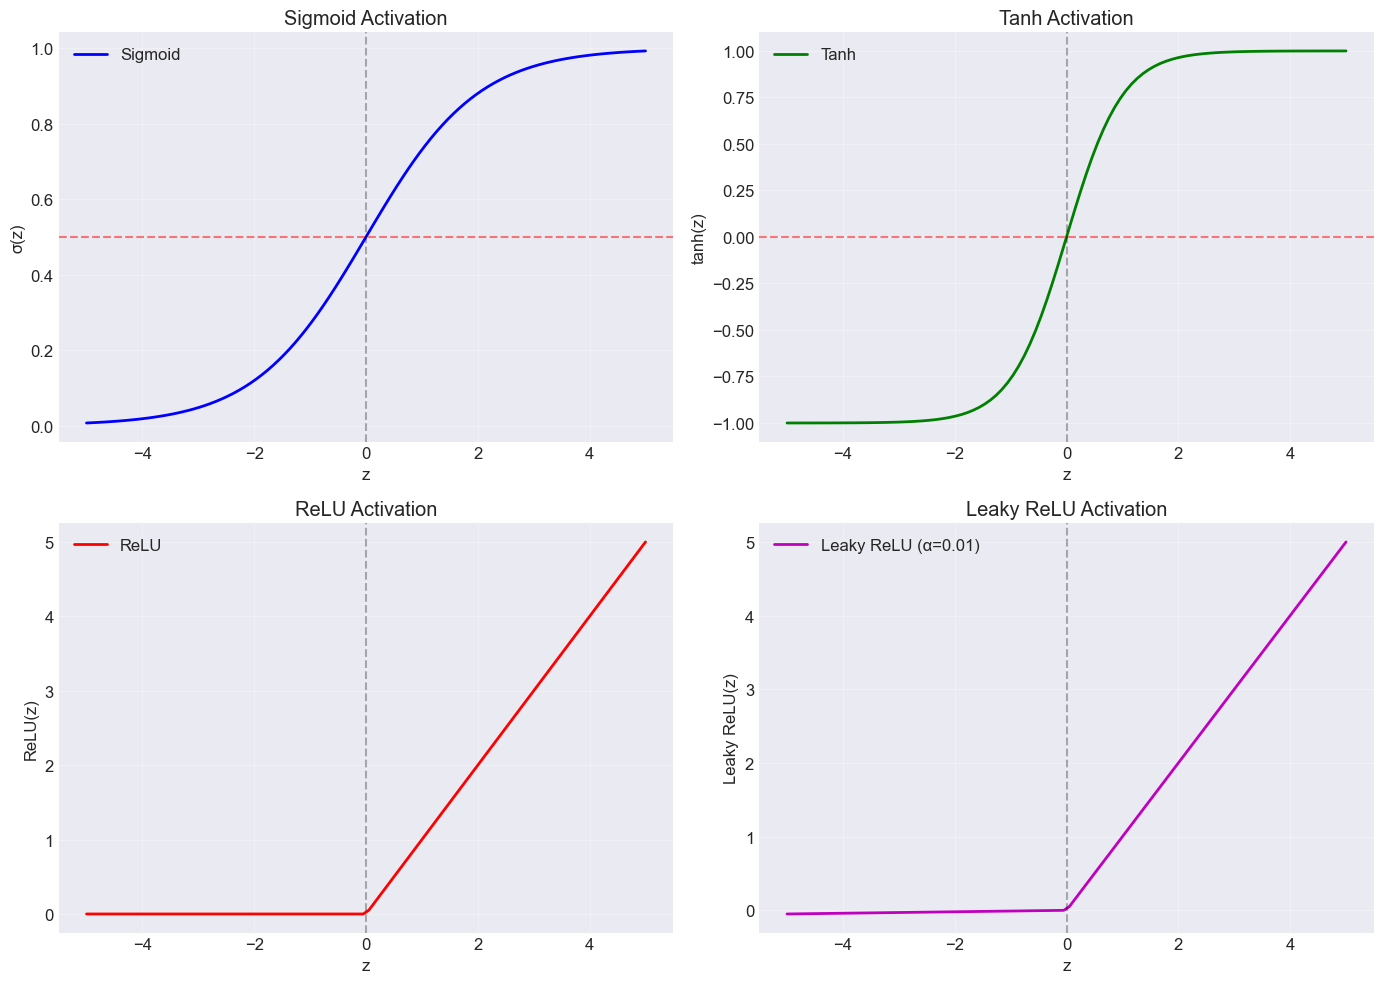

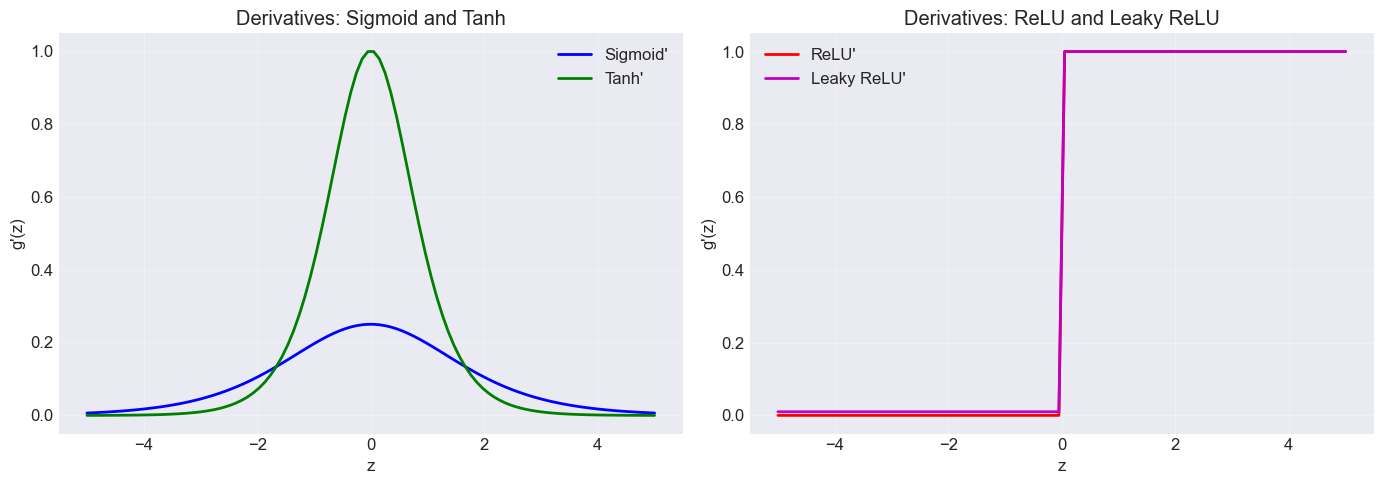

In [11]:
# Visualize activation functions
z = np.linspace(-5, 5, 100)

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

sigmoid_z = sigmoid(z)
tanh_z = tanh(z)
relu_z = relu(z)
leaky_relu_z = leaky_relu(z)

plt.figure(figsize=(14, 10))

# Plot activation functions
plt.subplot(2, 2, 1)
plt.plot(z, sigmoid_z, 'b-', linewidth=2, label='Sigmoid')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Sigmoid Activation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(z, tanh_z, 'g-', linewidth=2, label='Tanh')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('z')
plt.ylabel('tanh(z)')
plt.title('Tanh Activation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(z, relu_z, 'r-', linewidth=2, label='ReLU')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('z')
plt.ylabel('ReLU(z)')
plt.title('ReLU Activation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(z, leaky_relu_z, 'm-', linewidth=2, label='Leaky ReLU (α=0.01)')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('z')
plt.ylabel('Leaky ReLU(z)')
plt.title('Leaky ReLU Activation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot derivatives
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(z, sigmoid_z * (1 - sigmoid_z), 'b-', linewidth=2, label="Sigmoid'")
plt.plot(z, 1 - tanh_z**2, 'g-', linewidth=2, label="Tanh'")
plt.xlabel('z')
plt.ylabel("g'(z)")
plt.title('Derivatives: Sigmoid and Tanh')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
relu_deriv = (z > 0).astype(float)
leaky_relu_deriv = np.where(z > 0, 1, 0.01)
plt.plot(z, relu_deriv, 'r-', linewidth=2, label="ReLU'")
plt.plot(z, leaky_relu_deriv, 'm-', linewidth=2, label="Leaky ReLU'")
plt.xlabel('z')
plt.ylabel("g'(z)")
plt.title('Derivatives: ReLU and Leaky ReLU')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4.2 ReLU and Variants

### ReLU (Rectified Linear Unit)

$$\text{ReLU}(z) = \max(0, z) = \begin{cases} z & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

**Properties:**
- Simple and computationally efficient
- Solves vanishing gradient problem (for positive values)
- **Problem**: "Dying ReLU" - neurons can become inactive (output always 0)

**Derivative:**
$$\frac{d}{dz}\text{ReLU}(z) = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

### Leaky ReLU

$$\text{LeakyReLU}(z) = \begin{cases} z & \text{if } z > 0 \\ \alpha z & \text{if } z \leq 0 \end{cases}$$

where $\alpha$ is a small positive constant (typically 0.01).

**Properties:**
- Prevents "dying ReLU" problem
- Allows small negative gradients

### Other Variants

- **ELU (Exponential Linear Unit)**: Smooth version of ReLU
- **Swish**: $z \cdot \sigma(z)$
- **GELU**: Used in transformers

## 4.4.3 Choosing Activation Functions

### Guidelines

1. **Hidden Layers**: 
   - **ReLU** is the default choice for most cases
   - Use **Leaky ReLU** or **ELU** if you encounter dying ReLU problems
   - Avoid sigmoid/tanh for deep networks (vanishing gradients)

2. **Output Layer**:
   - **Regression**: Linear (no activation) or ReLU if outputs must be non-negative
   - **Binary Classification**: Sigmoid
   - **Multi-class Classification**: SoftMax

### Comparison

| Activation | Range | Pros | Cons |
|------------|-------|------|------|
| Sigmoid | (0,1) | Smooth, bounded | Vanishing gradients, not zero-centered |
| Tanh | (-1,1) | Zero-centered | Vanishing gradients |
| ReLU | [0,∞) | Fast, no vanishing gradient for z>0 | Dying ReLU problem |
| Leaky ReLU | (-∞,∞) | Prevents dying ReLU | Extra hyperparameter |

# 4.5 Building Neural Networks

## 4.5.1 Network Initialization

Proper weight initialization is crucial for training deep networks. Poor initialization can lead to:
- Vanishing gradients (weights too small)
- Exploding gradients (weights too large)
- Symmetry breaking issues

### Common Initialization Methods

1. **Xavier/Glorot Initialization**:
   $$W \sim \mathcal{N}\left(0, \frac{2}{n_{in} + n_{out}}\right)$$
   or
   $$W \sim \mathcal{U}\left(-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}\right)$$
   
   Good for sigmoid/tanh activations.

2. **He Initialization** (for ReLU):
   $$W \sim \mathcal{N}\left(0, \frac{2}{n_{in}}\right)$$
   
   Accounts for ReLU's zero output for half the inputs.

3. **Random Small Values**:
   $$W \sim \mathcal{N}(0, 0.01)$$
   
   Simple but can work for small networks.

In [12]:
# Complete MLP with Training
class MLPTrainer:
    """
    Complete MLP with training capabilities.
    """
    def __init__(self, layer_dims, activation='relu', output_activation='linear', 
                 initialization='xavier'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.output_activation = output_activation
        self.weights = []
        self.biases = []
        
        # Initialize weights
        for i in range(len(layer_dims) - 1):
            n_in, n_out = layer_dims[i], layer_dims[i+1]
            
            if initialization == 'xavier':
                limit = np.sqrt(6.0 / (n_in + n_out))
                w = np.random.uniform(-limit, limit, (n_out, n_in))
            elif initialization == 'he':
                std = np.sqrt(2.0 / n_in)
                w = np.random.randn(n_out, n_in) * std
            else:  # random small
                w = np.random.randn(n_out, n_in) * 0.01
            
            b = np.zeros((n_out, 1))
            self.weights.append(w)
            self.biases.append(b)
    
    def _activate(self, z, activation_type):
        """Apply activation function."""
        if activation_type == 'relu':
            return np.maximum(0, z)
        elif activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        elif activation_type == 'tanh':
            return np.tanh(z)
        elif activation_type == 'softmax':
            exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
            return exp_z / np.sum(exp_z, axis=0, keepdims=True)
        else:
            return z
    
    def forward(self, X):
        """Forward propagation."""
        cache = {'A': [X.T]}
        A = X.T
        
        for i in range(len(self.weights) - 1):
            Z = self.weights[i] @ A + self.biases[i]
            A = self._activate(Z, self.activation)
            cache['A'].append(A)
            cache[f'Z_{i}'] = Z
        
        i = len(self.weights) - 1
        Z = self.weights[i] @ A + self.biases[i]
        A = self._activate(Z, self.output_activation)
        cache['A'].append(A)
        cache[f'Z_{i}'] = Z
        
        return A.T, cache
    
    def compute_loss(self, y_pred, y_true, loss_type='mse'):
        """Compute loss."""
        m = y_true.shape[0]
        if loss_type == 'mse':
            return np.mean((y_pred - y_true)**2) / 2
        elif loss_type == 'cross_entropy':
            return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))
        else:
            return np.mean((y_pred - y_true)**2) / 2
    
    def backward(self, y, output, cache, loss_type='mse'):
        """Backward propagation."""
        m = y.shape[0]
        grads = {}
        
        # Output layer gradient
        if loss_type == 'mse':
            dA = (output - y) / m
        elif loss_type == 'cross_entropy':
            dA = -y / (output + 1e-15) / m
        else:
            dA = (output - y) / m
        
        L = len(self.weights) - 1
        Z_L = cache[f'Z_{L}']
        A_prev = cache['A'][L]
        
        if self.output_activation == 'sigmoid':
            dZ = dA.T * (output.T * (1 - output.T))
        elif self.output_activation == 'softmax':
            dZ = dA.T
        else:
            dZ = dA.T
        
        grads[f'dW_{L}'] = dZ @ A_prev.T
        grads[f'db_{L}'] = np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.weights[L].T @ dZ

        # Hidden layers: l = L-1 ... 0
        for l in range(L-1, -1, -1):
            Z_l = cache[f'Z_{l}']
            A_prev = cache['A'][l]
            
            if self.activation == 'relu':
                dZ = dA_prev * (Z_l > 0)
            elif self.activation == 'sigmoid':
                sig = 1 / (1 + np.exp(-np.clip(Z_l, -500, 500)))
                dZ = dA_prev * sig * (1 - sig)
            elif self.activation == 'tanh':
                dZ = dA_prev * (1 - np.tanh(Z_l)**2)
            else:
                dZ = dA_prev
            
            grads[f'dW_{l}'] = dZ @ A_prev.T
            grads[f'db_{l}'] = np.sum(dZ, axis=1, keepdims=True)
            
            if l > 0:
                dA_prev = self.weights[l].T @ dZ
        
        return grads
    
    def update_parameters(self, grads, learning_rate):
        """Update parameters using gradients."""
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads[f'dW_{i}']
            self.biases[i] -= learning_rate * grads[f'db_{i}']
    
    def train(self, X, y, epochs=1000, learning_rate=0.01, loss_type='mse', verbose=True):
        """Train the network."""
        loss_history = []
        
        for epoch in range(epochs):
            # Forward
            output, cache = self.forward(X)
            loss = self.compute_loss(output, y, loss_type)
            loss_history.append(loss)
            
            # Backward
            grads = self.backward(y, output, cache, loss_type)
            
            # Update
            self.update_parameters(grads, learning_rate)
            
            if verbose and (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history

Training MLP on XOR Problem:
Epoch 200/2000, Loss: 0.088990
Epoch 400/2000, Loss: 0.074066
Epoch 600/2000, Loss: 0.061131
Epoch 800/2000, Loss: 0.048249
Epoch 1000/2000, Loss: 0.036121
Epoch 1200/2000, Loss: 0.026619
Epoch 1400/2000, Loss: 0.019921
Epoch 1600/2000, Loss: 0.015399
Epoch 1800/2000, Loss: 0.012412
Epoch 2000/2000, Loss: 0.010229

Results:
Input | True | Predicted | Probability
---------------------------------------------
[0 0] |    0 |         0 | 0.2192
[0 1] |    1 |         1 | 0.8629
[1 0] |    1 |         1 | 0.9231
[1 1] |    0 |         0 | 0.0950

Accuracy: 100.00%


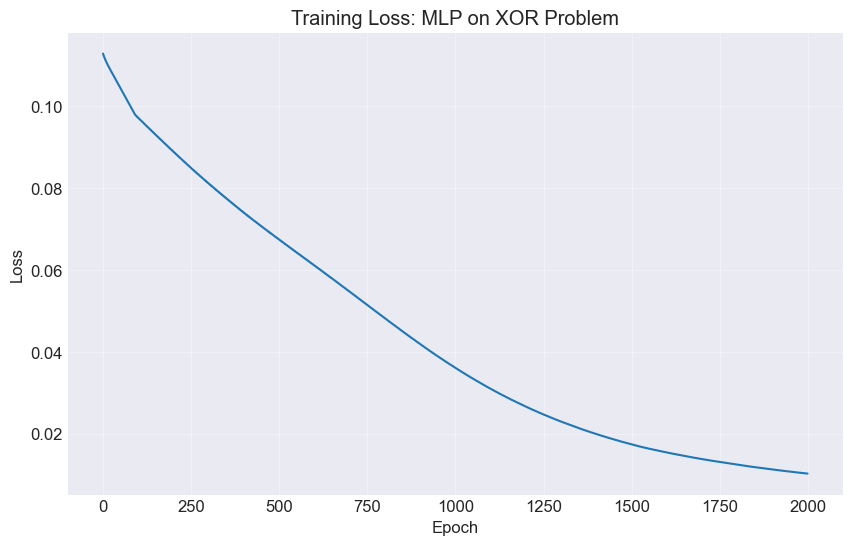

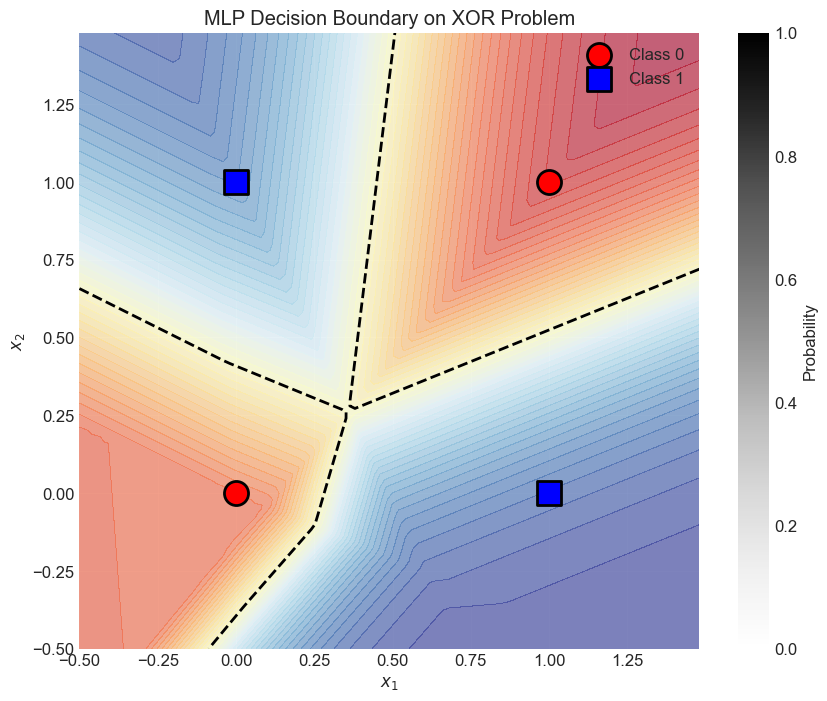

In [13]:
# Train MLP on XOR problem
print("Training MLP on XOR Problem:")
print("=" * 50)

X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

# Create and train network
mlp_xor = MLPTrainer(layer_dims=[2, 4, 1], activation='relu', 
                     output_activation='sigmoid', initialization='he')

loss_history = mlp_xor.train(X_xor, y_xor, epochs=2000, learning_rate=0.1, 
                             loss_type='mse', verbose=True)

# Test predictions
predictions, _ = mlp_xor.forward(X_xor)
pred_binary = (predictions > 0.5).astype(int)

print("\nResults:")
print("Input | True | Predicted | Probability")
print("-" * 45)
for i, (x, y_true, y_pred, prob) in enumerate(zip(X_xor, y_xor, pred_binary, predictions)):
    print(f"{x} | {y_true[0]:4d} | {y_pred[0]:9d} | {prob[0]:.4f}")

print(f"\nAccuracy: {accuracy_score(y_xor, pred_binary):.2%}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: MLP on XOR Problem')
plt.grid(True, alpha=0.3)
plt.show()

# Visualize decision boundary
h = 0.02
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z, _ = mlp_xor.forward(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')
colors = ['red' if y == 0 else 'blue' for y in y_xor.flatten()]
for i, (x, y, c) in enumerate(zip(X_xor, y_xor, colors)):
    plt.scatter(x[0], x[1], c=c, s=300, marker='o' if y[0] == 0 else 's',
                edgecolors='black', linewidths=2, label=f'Class {y[0]}' if i < 2 else '')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('MLP Decision Boundary on XOR Problem')
plt.legend()
plt.colorbar(label='Probability')
plt.grid(True, alpha=0.3)
plt.show()

## 4.5.3 Practical Considerations

### Data Preprocessing

1. **Normalization/Standardization**: Scale features to similar ranges
   - StandardScaler: $(x - \mu) / \sigma$
   - MinMaxScaler: $(x - x_{min}) / (x_{max} - x_{min})$

2. **Train/Validation/Test Split**: 
   - Training set: Used to learn parameters
   - Validation set: Used to tune hyperparameters
   - Test set: Used for final evaluation

### Regularization

1. **L2 Regularization (Weight Decay)**:
   $$L_{reg} = L + \lambda \sum_{l} \|W^{(l)}\|^2$$

2. **Dropout**: Randomly set some neurons to zero during training

3. **Early Stopping**: Stop training when validation loss stops improving

### Monitoring Training

- **Loss Curves**: Track training and validation loss
- **Accuracy Curves**: For classification tasks
- **Gradient Norms**: Check for vanishing/exploding gradients

Training MLP on Moons Dataset:
Epoch 100/1000, Loss: 0.113455
Epoch 200/1000, Loss: 0.092787
Epoch 300/1000, Loss: 0.079636
Epoch 400/1000, Loss: 0.071401
Epoch 500/1000, Loss: 0.065955
Epoch 600/1000, Loss: 0.062069
Epoch 700/1000, Loss: 0.059124
Epoch 800/1000, Loss: 0.056817
Epoch 900/1000, Loss: 0.054989
Epoch 1000/1000, Loss: 0.053500

Train Accuracy: 84.75%
Test Accuracy: 81.00%


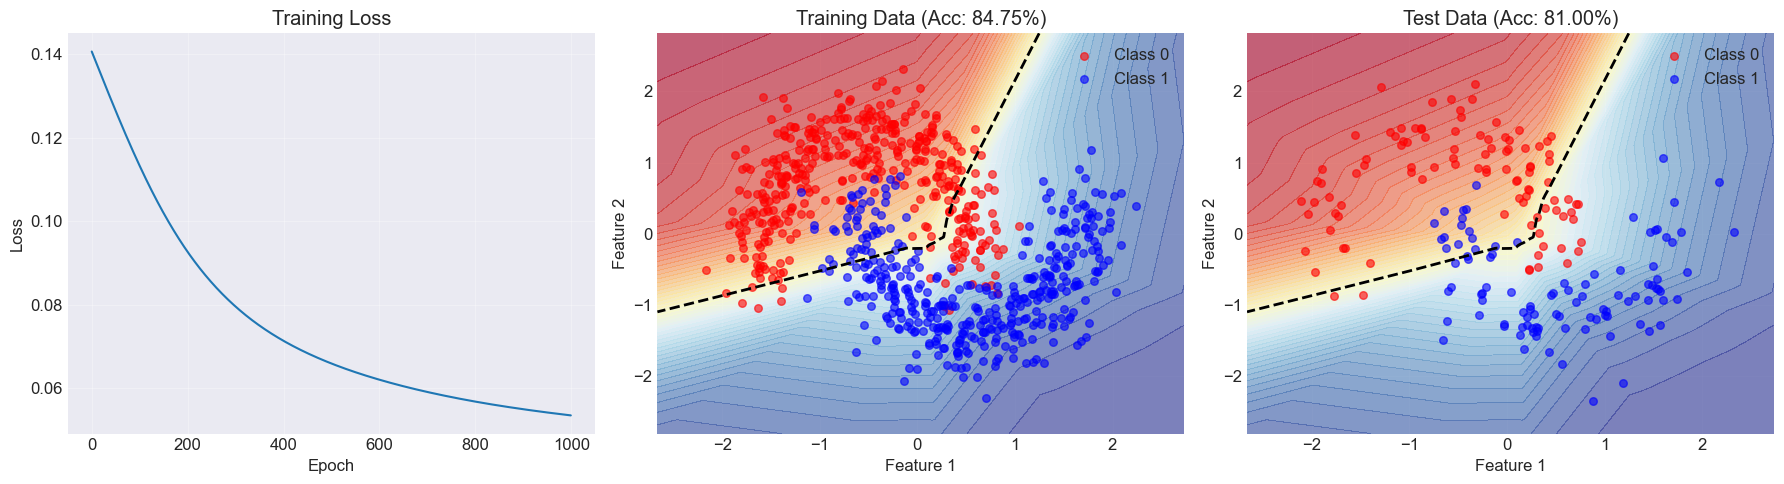

In [14]:
# Train on non-linearly separable data (moons dataset)
X_moons, y_moons = make_moons(n_samples=1000, noise=0.2, random_state=42)
y_moons = y_moons.reshape(-1, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.2, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP
print("Training MLP on Moons Dataset:")
print("=" * 50)

mlp_moons = MLPTrainer(layer_dims=[2, 10, 10, 1], activation='relu',
                       output_activation='sigmoid', initialization='he')

loss_history = mlp_moons.train(X_train_scaled, y_train, epochs=1000, 
                               learning_rate=0.01, loss_type='mse', verbose=True)

# Evaluate
train_pred, _ = mlp_moons.forward(X_train_scaled)
test_pred, _ = mlp_moons.forward(X_test_scaled)

train_acc = accuracy_score(y_train, (train_pred > 0.5).astype(int))
test_acc = accuracy_score(y_test, (test_pred > 0.5).astype(int))

print(f"\nTrain Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training loss
axes[0].plot(loss_history)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Plot 2: Decision boundary on training data
h = 0.02
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z, _ = mlp_moons.forward(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
axes[1].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')
scatter1 = axes[1].scatter(X_train_scaled[y_train.flatten() == 0, 0], 
                          X_train_scaled[y_train.flatten() == 0, 1],
                          c='red', alpha=0.6, s=30, label='Class 0')
scatter2 = axes[1].scatter(X_train_scaled[y_train.flatten() == 1, 0],
                          X_train_scaled[y_train.flatten() == 1, 1],
                          c='blue', alpha=0.6, s=30, label='Class 1')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title(f'Training Data (Acc: {train_acc:.2%})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Decision boundary on test data
axes[2].contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
axes[2].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2, linestyles='--')
axes[2].scatter(X_test_scaled[y_test.flatten() == 0, 0],
               X_test_scaled[y_test.flatten() == 0, 1],
               c='red', alpha=0.6, s=30, label='Class 0')
axes[2].scatter(X_test_scaled[y_test.flatten() == 1, 0],
               X_test_scaled[y_test.flatten() == 1, 1],
               c='blue', alpha=0.6, s=30, label='Class 1')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].set_title(f'Test Data (Acc: {test_acc:.2%})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In this chapter, we've covered:

### 4.1 Multi-Layer Perceptrons
- **4.1.1 From Linear to Non-Linear Models**: Limitations of linear models, XOR problem, need for hidden layers
- **4.1.2 Network Architecture**: Layer notation, network dimensions, matrix formulation
- **4.1.3 Layer Types**: Input, hidden, and output layers

### 4.2 Forward Propagation
- **4.2.1 Matrix Formulation**: Mathematical description of forward pass
- **4.2.2 Vectorized Implementation**: Batch processing for efficiency

### 4.3 Backpropagation
- **4.3.1 The Chain Rule**: Mathematical foundation
- **4.3.2 Gradient Computation**: Computing gradients for all parameters
- **4.3.3 Backpropagation Algorithm**: Complete algorithm for training

### 4.4 Activation Functions
- **4.4.1 Sigmoid and Tanh**: Traditional activation functions
- **4.4.2 ReLU and Variants**: Modern activation functions
- **4.4.3 Choosing Activation Functions**: Guidelines for selection

### 4.5 Building Neural Networks
- **4.5.1 Network Initialization**: Weight initialization strategies
- **4.5.2 Training Process**: Complete training loop
- **4.5.3 Practical Considerations**: Data preprocessing, regularization, monitoring

### Key Takeaways

- **Multi-layer networks** can learn non-linear patterns that linear models cannot
- **Forward propagation** computes predictions by passing data through the network
- **Backpropagation** computes gradients efficiently using the chain rule
- **Activation functions** introduce non-linearity (ReLU is the default choice)
- **Proper initialization** is crucial for training deep networks
- **Neural networks** can solve complex problems like XOR and non-linearly separable data

These concepts form the foundation for understanding and building deep neural networks. In the next chapters, we'll explore more advanced architectures and techniques.